In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, GaussianNoise, Flatten, Activation, Dropout, RepeatVector, Permute, Lambda, concatenate, dot, multiply
from tensorflow.keras.models import Model
from keras.layers import TimeDistributed
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

def normalize(data):
  min = np.min(data, axis = 0)
  max = np.max(data, axis = 0)
  #print('min, max',min, max)
  data = (data-min)/(max-min)
  return data

# Generate sample data
def generate_data(n_points, n_features, window_size, data = None):
    if data is None:
      data = np.random.randn(n_points, n_features)
    data = normalize(data)
    #data = np.random.normal(loc= 0.0, scale= 1.0 ,size = (n_points, n_features))
    X = []
    Y = []
    #print(data)
    for i in range(0, n_points-2*window_size+1):
      X.append(data[i:i+window_size,:])
      Y.append(data[i+window_size:i+2*window_size,:])
    return X, Y
# Parameters

n_features = 3
window_size = 5 # input = ouput = window_size


In [46]:
#n_train = 30

In [47]:
# # Generate data
# n_points = 1000
# n_train = int((n_points-2*window_size)*0.9)  #80% training samples
# X, Y = generate_data(n_points, n_features, window_size)
# print(len(X), len(Y))

# X_train, y_train = np.stack(X[:n_train]), np.stack(Y[:n_train])
# X_test, y_test = np.stack(X[n_train:]), np.stack(Y[n_train:])
# print(f'x_train: {X_train.shape}, y_train: {y_train.shape}, x_test: {X_test.shape}, y_train: {y_test.shape}')


In [48]:
# Import simulated data
import pandas as pd

#data = pd.read_csv(r"../content/simulated_data2_non_linear_01212023.csv")
data = pd.read_csv(r"../content/data_linear03_04022024.csv")
data = data.to_numpy().T
n_points = data.shape[0]
n_train = int((n_points-2*window_size)*0.9)  #80% training samples
# Generate data
X, Y = generate_data(n_points, n_features, window_size, data)
print(len(X), len(Y))

X_train, y_train = np.stack(X[:n_train]), np.stack(Y[:n_train])
X_test, y_test = np.stack(X[n_train:]), np.stack(Y[n_train:])
print(f'x_train: {X_train.shape}, y_train: {y_train.shape}, x_test: {X_test.shape}, y_test: {y_test.shape}')
X_test1,X_test2,X_test3 = X_test.copy(),X_test.copy(),X_test.copy()
X_test1[:,:,0] = 0 # To measure causality of variable x1 on other two variables
X_test2[:,:,1] = 0 # To measure causality of variable x2 on other two variables
X_test3[:,:,2] = 0 # To measure causality of variable x3 on other two variables

59982 59982
x_train: (53982, 5, 3), y_train: (53982, 5, 3), x_test: (6000, 5, 3), y_test: (6000, 5, 3)


In [49]:
# Define model
latent_dim = 128 #128(optimal)

dropout_rate = 0.4  # Example dropout rate

inputs = Input(shape=(None, n_features))
# First LSTM layer in the encoder with return_sequences=True
# encoded = LSTM(latent_dim, activation='selu', return_sequences=True, go_backwards=True)(inputs)
# encoded = Dropout(dropout_rate)(encoded)  # Adding dropout after the first LSTM layer
# Second LSTM layer in the encoder
encoded, state_h, state_c = LSTM(latent_dim, activation='selu', return_sequences=True, return_state=True)(inputs)
encoder_states = [state_h, state_c]

# Compute importance for each step
attention = Dense(1, activation='tanh')(encoded)
attention = Flatten()(attention)
attention = Activation('softmax', name='attention')(attention)
attention = RepeatVector(latent_dim)(attention)
attention = Permute([2, 1])(attention)

encoded = multiply([encoded, attention])
context = Lambda(lambda xin: tf.keras.backend.sum(xin, axis=1))(encoded)

# Decoder
decoder_input = Lambda(lambda x: tf.keras.backend.repeat(x[0], tf.shape(x[1])[1]))([context, inputs])
# First LSTM layer in the decoder with return_sequences=True
decoded = LSTM(latent_dim, activation='selu', return_state=False, return_sequences=True)(decoder_input, initial_state=encoder_states)
#decoded = Dropout(dropout_rate)(decoded)  # Adding dropout after the first LSTM layer
# Second LSTM layer in the decoder
# decoded = LSTM(latent_dim, activation='selu', return_sequences=True)(decoded)

attention = dot([decoded, encoded], axes=[2, 2])
attention = Activation('softmax')(attention)
attention = dot([attention, encoded], axes=[2,1])
decoded = concatenate([attention, decoded])

decoded = TimeDistributed(Dense(n_features), name='autoencoder')(decoded)

# Define models
encoder = Model(inputs, context)
autoencoder = Model(inputs, decoded)
autoencoder.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, None, 3)]            0         []                            
                                                                                                  
 lstm_10 (LSTM)              [(None, None, 128),          67584     ['input_6[0][0]']             
                              (None, 128),                                                        
                              (None, 128)]                                                        
                                                                                                  
 dense_10 (Dense)            (None, None, 1)              129       ['lstm_10[0][0]']             
                                                                                           

Epoch 1/2000
3037/3037 [==============================] - 45s 14ms/step - loss: 7.8870e-04 - val_loss: 6.6751e-04
Epoch 2/2000
3037/3037 [==============================] - 41s 13ms/step - loss: 4.9255e-04 - val_loss: 4.0890e-04
Epoch 3/2000
3037/3037 [==============================] - 42s 14ms/step - loss: 4.2760e-04 - val_loss: 4.2528e-04
Epoch 4/2000
3037/3037 [==============================] - 41s 14ms/step - loss: 4.1546e-04 - val_loss: 4.7225e-04
Epoch 5/2000
3037/3037 [==============================] - 43s 14ms/step - loss: 4.0915e-04 - val_loss: 3.9066e-04
Epoch 6/2000
3037/3037 [==============================] - 42s 14ms/step - loss: 4.0621e-04 - val_loss: 3.8910e-04
Epoch 7/2000
3037/3037 [==============================] - 42s 14ms/step - loss: 3.9894e-04 - val_loss: 3.8709e-04
Epoch 8/2000
3037/3037 [==============================] - 43s 14ms/step - loss: 3.9932e-04 - val_loss: 3.9125e-04
Epoch 9/2000
3037/3037 [==============================] - 42s 14ms/step - loss: 3.9653e-

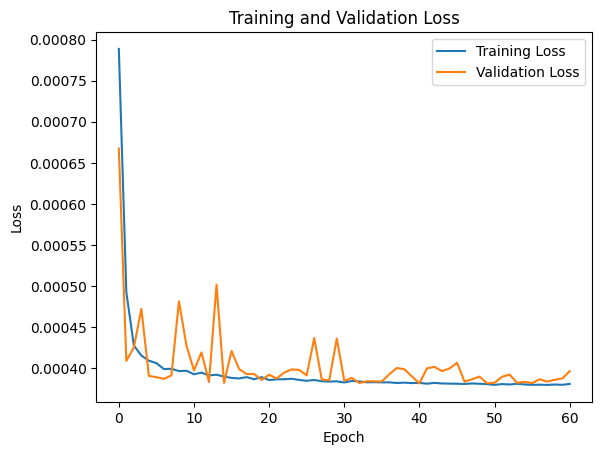

188/188 [==============================] - 2s 11ms/step
mean Test MAE: 0.015242143178662668
mean Test MSE: 0.00037642055867959237
mean Test RMSE: 0.019401560727930946
mean Test R-squared: 0.9675586702007065
Test MAE: [0.014811324583087556, 0.014660104338064812, 0.016255000614835417]
Test MSE: [0.00035657779859881014, 0.0003455854291972989, 0.0004270984482426687]
Test MSE: [0.018883267688586374, 0.018589928165469033, 0.020666360304675536]
Test R-squared: [0.9683100202062177, 0.970772179237925, 0.9635938111579757]


In [50]:
# Compile model
autoencoder.compile(optimizer="adam", loss="mse")

# Train model
es = EarlyStopping(monitor='val_loss', patience=20, verbose=0, restore_best_weights=True)
history = autoencoder.fit(X_train, y_train, epochs=2000, batch_size=16, verbose=1, validation_split=0.1, callbacks = [es])

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

y_pred = autoencoder.predict(X_test)
#print(y_pred.shape, y_pred)
yy_pred = y_pred.reshape(-1,3)
yy_test = y_test.reshape(-1,3)

mse = mean_squared_error(yy_test, yy_pred)
mae = mean_absolute_error(yy_test, yy_pred)
r2 = r2_score(yy_test, yy_pred)

print("mean Test MAE:", mae)
print("mean Test MSE:", mse)
print("mean Test RMSE:", np.sqrt(mse))
print("mean Test R-squared:", r2)

mse = []
mae = []
rmse = []
r2 = []
for i in range(3):
  mse.append(mean_squared_error(yy_test[:,i], yy_pred[:,i]))  #self causal when i ==0
  mae.append(mean_absolute_error(yy_test[:,i], yy_pred[:,i]))
  rmse.append(np.sqrt(mean_squared_error(yy_test[:,i], yy_pred[:,i])))
  r2.append(r2_score(yy_test[:,i], yy_pred[:,i]))

print("Test MAE:", mae)
print("Test MSE:", mse)
print("Test MSE:", rmse)
print("Test R-squared:", r2)


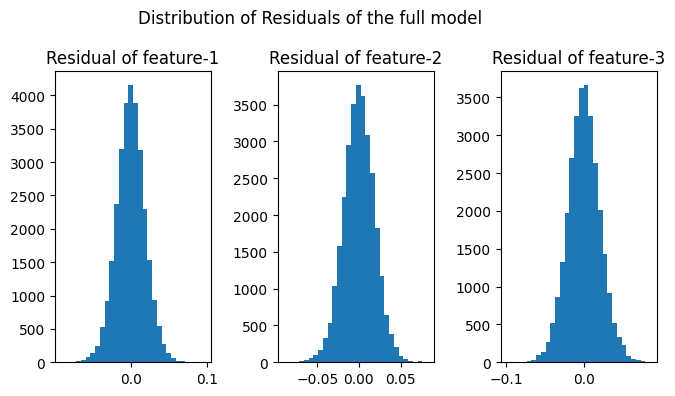

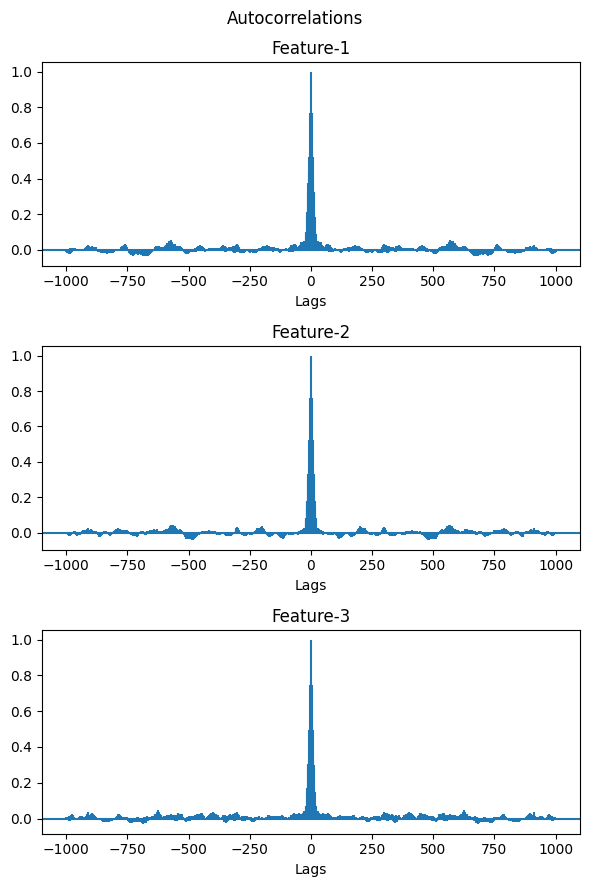

In [51]:
#Code for distribution of residual. See if they are normally distributed.
import seaborn as sns
plt.figure(figsize= (9,4))
plt.suptitle('Distribution of Residuals of the full model', x= 0.35)
for i in range(n_features):
  plt.subplot(1,n_features+1,i+1)
  residuals = yy_test[:,i]- yy_pred[:,i]
  plt.hist(residuals, bins = 30) #, bins = 5
  #sns.kdeplot(residuals, color='r', linewidth=2)
  plt.title('Residual of feature-'+str(i+1))
plt.tight_layout()
plt.show()
plt.close()

#Code for auto correlation of the residuals
from pandas import DataFrame
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(6,9))
plt.suptitle('Autocorrelations')
for i in range(n_features):
  plt.subplot(n_features, 1, i+1)
  residuals =  yy_test[:,i]-yy_pred[:,i]
  # residuals = DataFrame(residuals)
  # autocorrelation_plot(residuals)
  plt.acorr(yy_test[:,i]-yy_pred[:,i], maxlags = 1000)
  plt.title(f'Feature-{i+1}')
  plt.xlabel('Lags')
plt.tight_layout()
plt.show()
plt.close()

In [52]:
mse = []
mae = []
rmse = []
r2 = []
variance = []
for i in range(3):
  variance.append(np.var(yy_test[:,i]-yy_pred[:,i]))
  mse.append(mean_squared_error(yy_test[:,i], yy_pred[:,i]))  #self causal when i ==0
  mae.append(mean_absolute_error(yy_test[:,i], yy_pred[:,i]))
  rmse.append(np.sqrt(mean_squared_error(yy_test[:,i], yy_pred[:,i])))
  r2.append(r2_score(yy_test[:,i], yy_pred[:,i]))
print('variance: ',variance)
print("Test MAE:", mae)
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)

variance:  [0.000356569556522337, 0.00034557794027372863, 0.00042696025888765886]
Test MAE: [0.014811324583087556, 0.014660104338064812, 0.016255000614835417]
Test MSE: [0.00035657779859881014, 0.0003455854291972989, 0.0004270984482426687]
Test RMSE: [0.018883267688586374, 0.018589928165469033, 0.020666360304675536]
Test R-squared: [0.9683100202062177, 0.970772179237925, 0.9635938111579757]


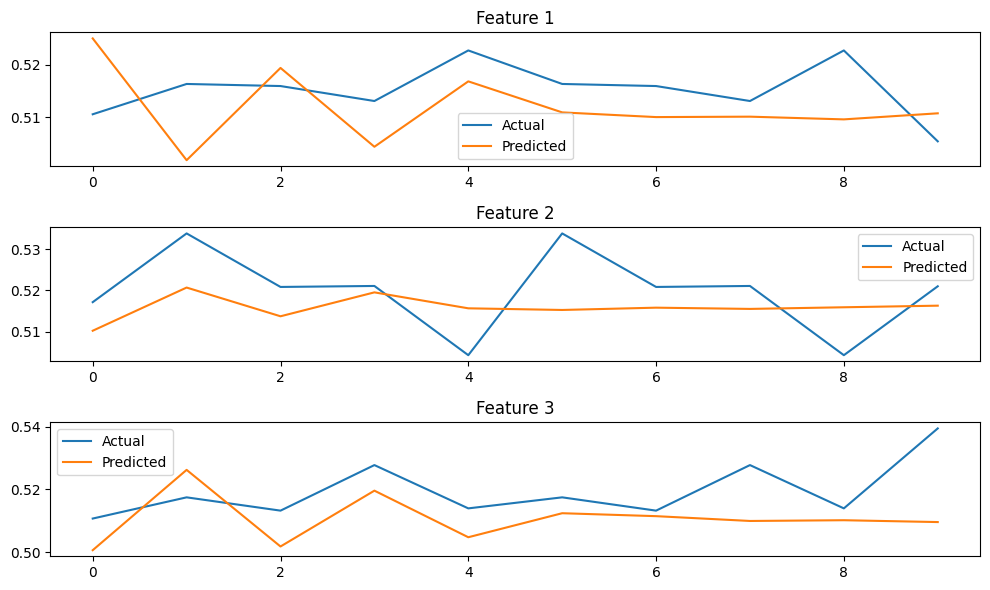

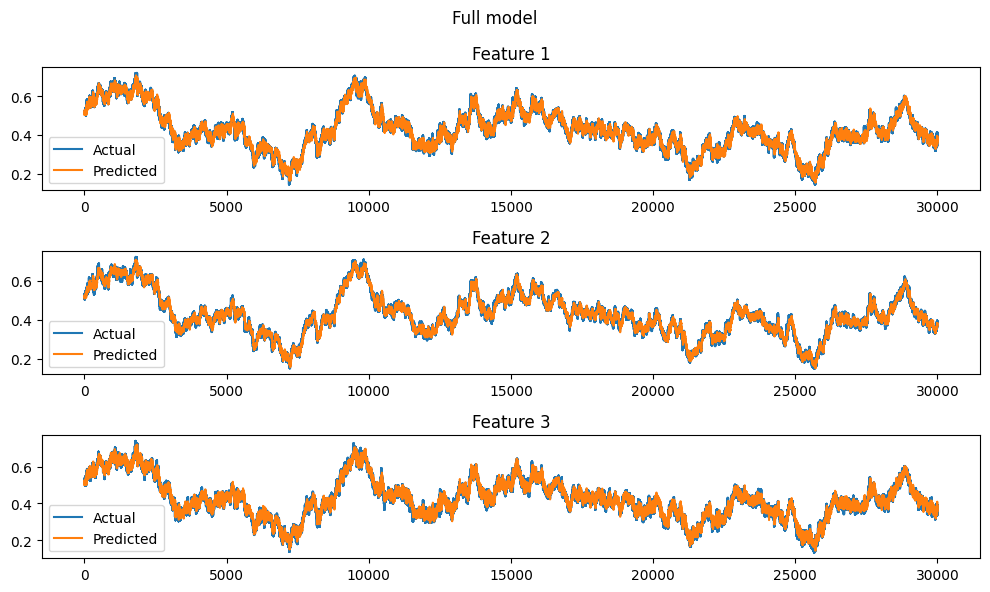

In [53]:
# Plotting of Actual and predicted (Full model) signal
plt.figure(figsize=(10, 6))
for i in range(n_features):
    plt.subplot(n_features, 1, i+1)
    plt.plot(yy_test[0:2*window_size, i], label='Actual')
    plt.plot(yy_pred[0:2*window_size, i], label='Predicted')
    plt.title(f'Feature {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(10, 6))
plt.suptitle('Full model')
for i in range(n_features):
    plt.subplot(n_features, 1, i+1)
    plt.plot(yy_test[:, i], label='Actual')
    plt.plot(yy_pred[:, i], label='Predicted')
    plt.title(f'Feature {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()
plt.close()

188/188 [==============================] - 1s 8ms/step
Test MAE: [0.14527711148987962, 0.16459839128087575, 0.1855083938610768]
Test MSE: [0.023989041997831664, 0.028912880388193507, 0.03966370420382887]
Test RMSE: [0.15488396301047977, 0.17003787927457079, 0.1991574859346966]
Test R-squared: [-1.1319674392818935, -1.445301260716568, -2.3809635960052296]
variance:  [0.00288360287498876, 0.001820249975941223, 0.005250825611093573]


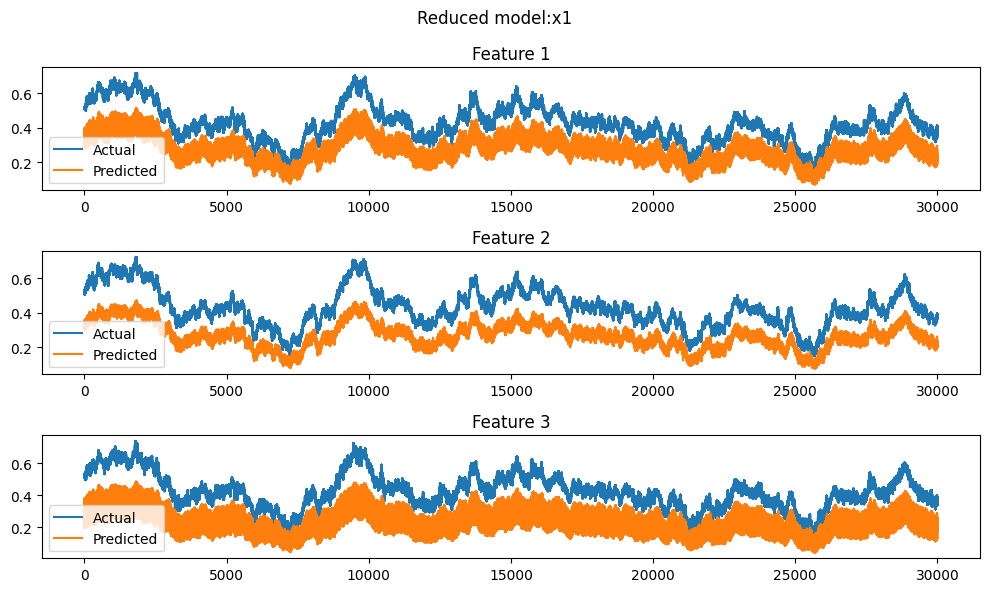

causal1: [2.09026646 1.66151092 2.50944966]


In [54]:
# Causal effect of x1 features on other variables
y_pred1 = autoencoder.predict(X_test1)
#print(y_pred.shape, y_pred)
yy_pred1 = y_pred1.reshape(-1,3)
yy_test = y_test.reshape(-1,3)
mse = []
mae = []
rmse = []
r2 = []
for i in range(3):
  mse.append(mean_squared_error(yy_test[:,i], yy_pred1[:,i]))  #self causal when i ==0
  mae.append(mean_absolute_error(yy_test[:,i], yy_pred1[:,i]))
  rmse.append(np.sqrt(mean_squared_error(yy_test[:,i], yy_pred1[:,i])))
  r2.append(r2_score(yy_test[:,i], yy_pred1[:,i]))

print("Test MAE:", mae)
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
variance1 = []
plt.figure(figsize=(10, 6))
plt.suptitle('Reduced model:x1')
for i in range(n_features):
    variance1.append(np.var(yy_test[:,i]-yy_pred1[:,i]))
    plt.subplot(n_features, 1, i+1)
    plt.plot(yy_test[:, i], label='Actual')
    plt.plot(yy_pred1[:, i], label='Predicted')
    plt.title(f'Feature {i+1}')
    plt.legend()
print('variance: ',variance1)

plt.tight_layout()
plt.show()
plt.close()

causal1 = np.log(np.array(variance1)/np.array(variance))
print('causal1:', causal1)

188/188 [==============================] - 2s 8ms/step
Test MAE: [0.15665491612782828, 0.17546467897525048, 0.13612982567015833]
Test MSE: [0.026757133324757328, 0.03312115758582741, 0.021568450441042032]
Test RMSE: [0.16357607809443692, 0.18199219100232683, 0.1468620115654216]
Test R-squared: [-1.3779747862404572, -1.8012154898993886, -0.8385107298265555]


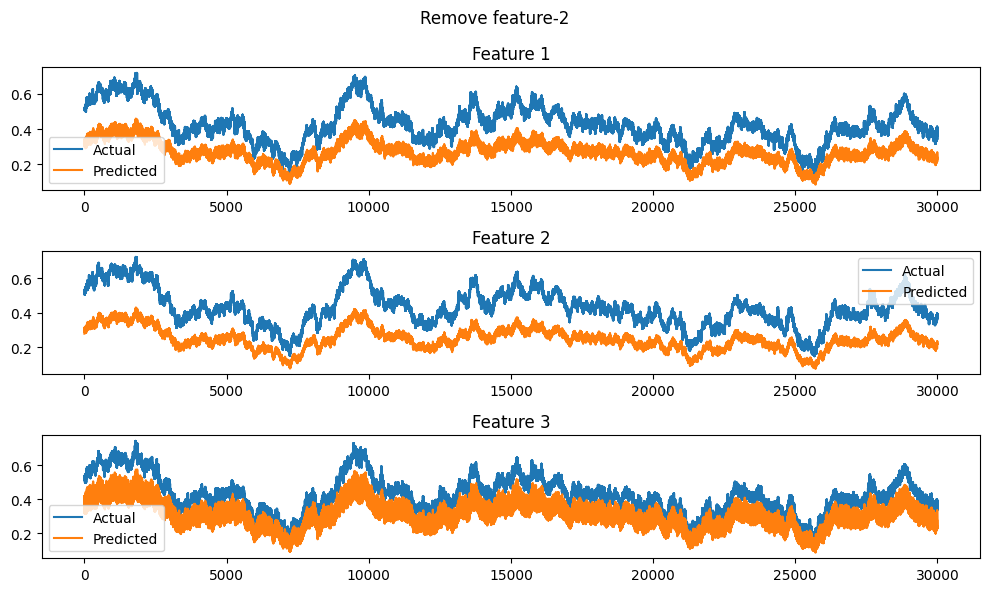

causal2: [1.82709693 1.90982237 1.96252377]


In [55]:
# Causal effect of x2 features on other variables
y_pred2 = autoencoder.predict(X_test2)
#print(y_pred.shape, y_pred)
yy_pred2 = y_pred2.reshape(-1,3)
yy_test = y_test.reshape(-1,3)
mse = []
mae = []
rmse = []
r2 = []
for i in range(3):
  mse.append(mean_squared_error(yy_test[:,i], yy_pred2[:,i]))  #self causal when i ==0
  mae.append(mean_absolute_error(yy_test[:,i], yy_pred2[:,i]))
  rmse.append(np.sqrt(mean_squared_error(yy_test[:,i], yy_pred2[:,i])))
  r2.append(r2_score(yy_test[:,i], yy_pred2[:,i]))

print("Test MAE:", mae)
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)

variance2 = []
plt.figure(figsize=(10, 6))
plt.suptitle('Remove feature-2')
for i in range(n_features):
    variance2.append(np.var(yy_test[:,i]-yy_pred2[:,i]))
    plt.subplot(n_features, 1, i+1)
    plt.plot(yy_test[:, i], label='Actual')
    plt.plot(yy_pred2[:, i], label='Predicted')
    plt.title(f'Feature {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()
plt.close()

causal2 = np.log(np.array(variance2)/np.array(variance))
print('causal2:', causal2)

188/188 [==============================] - 2s 12ms/step
Test MAE: [0.08314644975925502, 0.0642605814669671, 0.07197741471430708]
Test MSE: [0.008854705624583572, 0.005404047696598315, 0.006684567480246195]
Test RMSE: [0.09409944539997869, 0.07351222821135485, 0.08175920425399329]
Test R-squared: [0.21305969293209925, 0.5429537123924727, 0.43020250479855315]


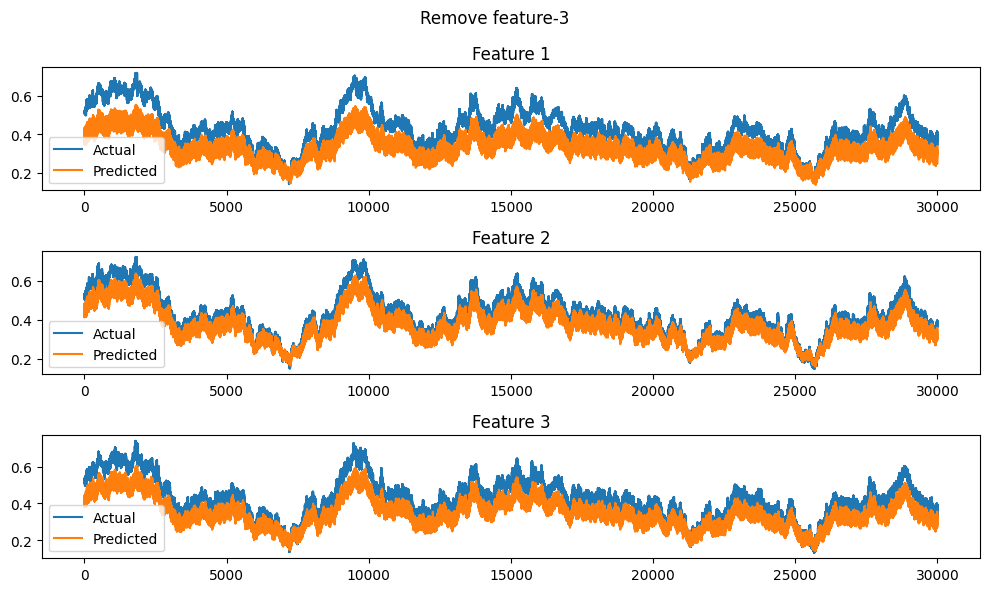

causal3: [1.76507394 1.39007776 1.39524828]


In [56]:
# Causal effect of x3 features on other variables
y_pred3 = autoencoder.predict(X_test3)
#print(y_pred.shape, y_pred)
yy_pred3 = y_pred3.reshape(-1,3)
yy_test = y_test.reshape(-1,3)
mse = []
mae = []
rmse = []
r2 = []
for i in range(3):
  mse.append(mean_squared_error(yy_test[:,i], yy_pred3[:,i]))  # self causal when i ==0
  mae.append(mean_absolute_error(yy_test[:,i], yy_pred3[:,i]))
  rmse.append(np.sqrt(mean_squared_error(yy_test[:,i], yy_pred3[:,i])))
  r2.append(r2_score(yy_test[:,i], yy_pred3[:,i]))

print("Test MAE:", mae)
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)

variance3 = []
plt.figure(figsize=(10, 6))
plt.suptitle('Remove feature-3')
for i in range(n_features):
    variance3.append(np.var(yy_test[:,i]-yy_pred3[:,i]))
    plt.subplot(n_features, 1, i+1)
    plt.plot(yy_test[:, i], label='Actual')
    plt.plot(yy_pred3[:, i], label='Predicted')
    plt.title(f'Feature {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()
plt.close()

causal3 = np.log(np.array(variance3)/np.array(variance))
print('causal3:', causal3)